# Task4 建模调参 

## 四、建模与调参


**赛题：零基础入门数据挖掘 - 二手车交易价格预测**

地址：https://tianchi.aliyun.com/competition/entrance/231784/introduction?spm=5176.12281957.1004.1.38b02448ausjSX 
    

## 4.1 学习目标

* 了解常用的机器学习模型，并掌握机器学习模型的建模与调参流程
* 完成相应学习打卡任务

## 4.2 学习内容

1. 线性回归模型：
    - 线性回归对于特征的要求；
    - 处理长尾分布；
    - 理解线性回归模型；
2. 模型性能验证：
    - 评价函数与目标函数；
    - 交叉验证方法；
    - 留一验证方法；
    - 针对时间序列问题的验证；
    - 绘制学习率曲线；
    - 绘制验证曲线；
3. 嵌入式特征选择：
    - Lasso回归；
    - Ridge回归；
    - 决策树；
4. 模型对比：
    - 常用线性模型；
    - 常用非线性模型；
5. 模型调参：
    - 贪心调参方法；
    - 网格调参方法；
    - 贝叶斯调参方法；

## 4.3 相关原理介绍与推荐

由于相关算法原理篇幅较长，本文推荐了一些博客与教材供初学者们进行学习。

### 4.3.1 线性回归模型

https://zhuanlan.zhihu.com/p/49480391

### 4.3.2 决策树模型

https://zhuanlan.zhihu.com/p/65304798

### 4.3.3 GBDT模型

https://zhuanlan.zhihu.com/p/45145899

### 4.3.4 XGBoost模型

https://zhuanlan.zhihu.com/p/86816771

### 4.3.5 LightGBM模型

https://zhuanlan.zhihu.com/p/89360721

### 4.3.6 推荐教材：

   - 《机器学习》 https://book.douban.com/subject/26708119/
   - 《统计学习方法》 https://book.douban.com/subject/10590856/
   - 《Python大战机器学习》 https://book.douban.com/subject/26987890/
   - 《面向机器学习的特征工程》 https://book.douban.com/subject/26826639/
   - 《数据科学家访谈录》 https://book.douban.com/subject/30129410/


## 4.4 运行代码

### 4.4.1 读取数据

* pip install sklearn

* pip install xgboost

* pip install lightgbm

* pip install bayesian-optimization

In [71]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [5]:
continuous_feature_names

['SaleID',
 'bodyType',
 'fuelType',
 'gearbox',
 'kilometer',
 'name',
 'notRepairedDamage',
 'offerType',
 'power',
 'seller',
 'train',
 'v_0',
 'v_1',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'used_time',
 'city',
 'brand_amount',
 'brand_price_max',
 'brand_price_median',
 'brand_price_min',
 'brand_price_sum',
 'brand_price_std',
 'brand_price_average',
 'power_bin']

### 4.4.2 线性回归 & 五折交叉验证 & 模拟真实业务情况

In [8]:
sample_feature.shape

(199037, 39)

In [9]:
sample_feature.dropna()

,SaleID,bodyType,brand,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,1.0,6,0.0,0.0,12.5,30.0,736,0.0,0,...,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
2,2,1.0,15,0.0,0.0,12.5,115.0,14874,0.0,0,...,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
4,4,1.0,5,0.0,0.0,5.0,110.0,111080,0.0,0,...,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15414322.0,3344.0,3306.0,6.0
5,5,0.0,10,1.0,0.0,10.0,24.0,137642,0.0,0,...,2482.0,3.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,10.0
6,6,0.0,4,0.0,1.0,15.0,13.0,2402,0.0,0,...,6184.0,3.0,16576.0,99999.0,6000.0,12.0,138279072.0,8088.0,8344.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149031,149994,1.0,1,0.0,0.0,3.0,42.0,43073,0.0,0,...,1538.0,5.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,12.0
149032,149995,4.0,10,0.0,1.0,15.0,121.0,163978,0.0,0,...,5772.0,4.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,16.0
149033,149996,0.0,11,0.0,0.0,10.0,116.0,184535,0.0,0,...,2322.0,2.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,12.0
149034,149997,1.0,11,1.0,0.0,6.0,60.0,147587,0.0,0,...,2003.0,3.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,8.0


In [10]:
sample_feature.dropna().replace('-', 0)

,SaleID,bodyType,brand,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,1.0,6,0.0,0.0,12.5,30.0,736,0.0,0,...,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
2,2,1.0,15,0.0,0.0,12.5,115.0,14874,0.0,0,...,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
4,4,1.0,5,0.0,0.0,5.0,110.0,111080,0.0,0,...,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15414322.0,3344.0,3306.0,6.0
5,5,0.0,10,1.0,0.0,10.0,24.0,137642,0.0,0,...,2482.0,3.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,10.0
6,6,0.0,4,0.0,1.0,15.0,13.0,2402,0.0,0,...,6184.0,3.0,16576.0,99999.0,6000.0,12.0,138279072.0,8088.0,8344.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149031,149994,1.0,1,0.0,0.0,3.0,42.0,43073,0.0,0,...,1538.0,5.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,12.0
149032,149995,4.0,10,0.0,1.0,15.0,121.0,163978,0.0,0,...,5772.0,4.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,16.0
149033,149996,0.0,11,0.0,0.0,10.0,116.0,184535,0.0,0,...,2322.0,2.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,12.0
149034,149997,1.0,11,1.0,0.0,6.0,60.0,147587,0.0,0,...,2003.0,3.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,8.0


In [11]:
sample_feature.dropna().replace('-', 0).reset_index(drop=True)

,SaleID,bodyType,brand,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,1.0,6,0.0,0.0,12.5,30.0,736,0.0,0,...,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
1,2,1.0,15,0.0,0.0,12.5,115.0,14874,0.0,0,...,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
2,4,1.0,5,0.0,0.0,5.0,110.0,111080,0.0,0,...,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15414322.0,3344.0,3306.0,6.0
3,5,0.0,10,1.0,0.0,10.0,24.0,137642,0.0,0,...,2482.0,3.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,10.0
4,6,0.0,4,0.0,1.0,15.0,13.0,2402,0.0,0,...,6184.0,3.0,16576.0,99999.0,6000.0,12.0,138279072.0,8088.0,8344.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91724,149994,1.0,1,0.0,0.0,3.0,42.0,43073,0.0,0,...,1538.0,5.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,12.0
91725,149995,4.0,10,0.0,1.0,15.0,121.0,163978,0.0,0,...,5772.0,4.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,16.0
91726,149996,0.0,11,0.0,0.0,10.0,116.0,184535,0.0,0,...,2322.0,2.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,12.0
91727,149997,1.0,11,1.0,0.0,6.0,60.0,147587,0.0,0,...,2003.0,3.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,8.0


In [19]:
type(sample_feature['price'].dtype)

numpy.dtype

In [21]:
str(sample_feature['price'].dtype)

'float32'

In [17]:
continuous_feature_names + ['price']

['SaleID',
 'bodyType',
 'fuelType',
 'gearbox',
 'kilometer',
 'name',
 'notRepairedDamage',
 'offerType',
 'power',
 'seller',
 'train',
 'v_0',
 'v_1',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'used_time',
 'city',
 'brand_amount',
 'brand_price_max',
 'brand_price_median',
 'brand_price_min',
 'brand_price_sum',
 'brand_price_std',
 'brand_price_average',
 'power_bin',
 'price']

In [18]:
type(continuous_feature_names)

list

In [22]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

#### 4.4.2 - 1 简单建模

In [23]:
from sklearn.linear_model import LinearRegression

In [27]:
model = LinearRegression(normalize=True)

In [29]:
model = model.fit(train_X, train_y)

查看训练的线性回归模型的截距（intercept）与权重(coef)

In [30]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416419127),
 ('v_8', 700675.5609398747),
 ('v_9', 170630.27723219778),
 ('v_7', 32322.66193202066),
 ('v_12', 20473.670796956518),
 ('v_3', 17868.079541495277),
 ('v_11', 11474.93899667472),
 ('v_13', 11261.764560013775),
 ('v_10', 2683.920090636247),
 ('gearbox', 881.8225039248076),
 ('fuelType', 363.9042507217425),
 ('bodyType', 189.60271012071334),
 ('city', 44.94975120521506),
 ('power', 28.553901616753308),
 ('brand_price_median', 0.5103728134078945),
 ('brand_price_std', 0.4503634709263306),
 ('brand_amount', 0.1488112039506502),
 ('brand_price_max', 0.0031910186703142654),
 ('SaleID', 5.355989919859153e-05),
 ('seller', 1.7292331904172897e-05),
 ('offerType', -3.609340637922287e-06),
 ('train', -8.841510862112045e-06),
 ('brand_price_sum', -2.1750068681876416e-05),
 ('name', -0.0002980012713070219),
 ('used_time', -0.0025158943328975666),
 ('brand_price_average', -0.4049048451011582),
 ('brand_price_min', -2.2467753486897433),
 ('power_bin', -34.42064411727693)

In [31]:
from matplotlib import pyplot as plt

In [32]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

In [35]:
train_X['v_9'][subsample_index]

59420    0.085938
78913    0.066223
39884    0.106995
87706    0.082092
73974    0.033691
82307    0.084045
34017    0.053619
55944    0.068298
42034    0.130127
1201     0.143311
51742    0.032837
64533    0.087280
72427    0.062042
86012    0.024200
23359    0.013344
57728    0.123047
12368    0.062012
20233    0.091431
38998    0.095032
34582    0.034943
91636    0.075317
52548    0.014694
59026    0.052765
89827    0.060394
64019    0.089905
18876    0.034302
3745     0.085632
32782    0.019348
41877    0.025101
68433    0.068848
85062    0.053162
44666    0.117004
51268    0.149658
49455    0.042267
80272    0.079895
53880    0.041046
84581    0.077637
27045    0.107483
80999    0.096802
10948    0.123047
23771    0.042603
47688    0.030212
64225    0.019760
10636    0.085876
43777    0.000874
49360    0.098633
30443    0.115356
90034    0.020050
62206    0.017807
78444    0.033356
Name: v_9, dtype: float64

The predicted price is obvious different from true price


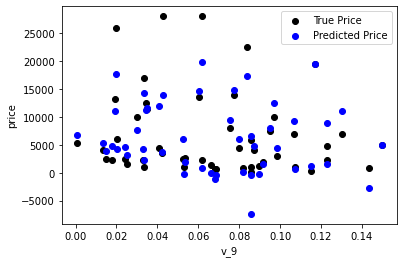

In [36]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。参考博客：https://blog.csdn.net/Noob_daniel/article/details/76087829

It is clear to see the price shows a typical exponential distribution


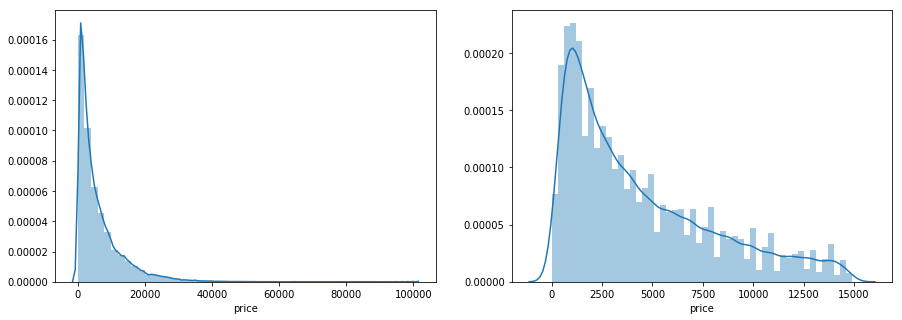

In [13]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

在这里我们对标签进行了 $log(x+1)$ 变换，使标签贴近于正态分布

In [37]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


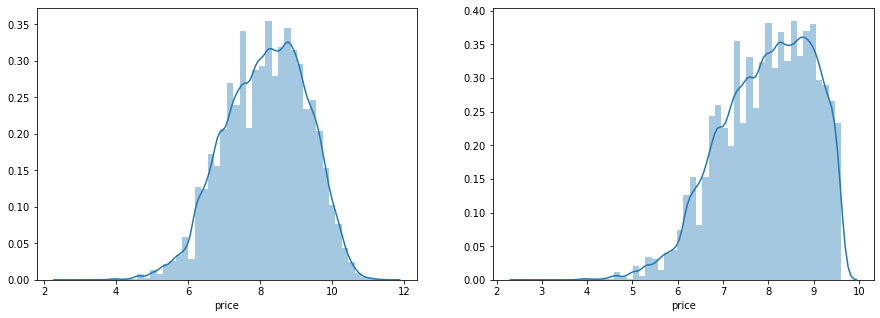

In [38]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [39]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750749465596538


[('v_9', 8.052409900567598),
 ('v_5', 5.764236596653164),
 ('v_12', 1.6182081236790842),
 ('v_1', 1.479831058297348),
 ('v_11', 1.1669016563604946),
 ('v_13', 0.9404711296033863),
 ('v_7', 0.7137273083565177),
 ('v_3', 0.6837875771083749),
 ('v_0', 0.00850051800990644),
 ('power_bin', 0.00849796930289138),
 ('gearbox', 0.007922377278334032),
 ('fuelType', 0.006684769706830405),
 ('bodyType', 0.004523520092703996),
 ('power', 0.0007161894205359879),
 ('brand_price_min', 3.334351114751914e-05),
 ('brand_amount', 2.8978797042783603e-06),
 ('brand_price_median', 1.2571172872987556e-06),
 ('brand_price_std', 6.659176363456033e-07),
 ('brand_price_max', 6.194956307516954e-07),
 ('brand_price_average', 5.999345965077057e-07),
 ('SaleID', 2.11941700396436e-08),
 ('seller', 3.923616986867273e-11),
 ('train', -1.5702994460298214e-11),
 ('offerType', -2.2708945834892802e-11),
 ('brand_price_sum', -1.5126504215939166e-10),
 ('name', -7.015512588894369e-08),
 ('used_time', -4.122479372349444e-06),


再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况

The predicted price seems normal after np.log transforming


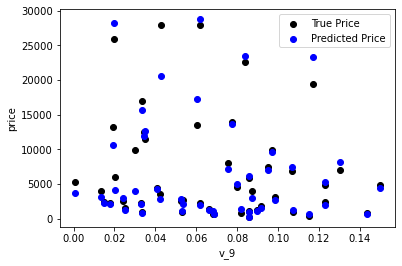

In [40]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

#### 4.4.2 - 2 五折交叉验证

> 在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

>因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [42]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [43]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）

In [44]:
print('AVG:', np.mean(scores))

AVG: 1.3658023920314064


使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 0.19）

In [45]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [46]:
print('AVG:', np.mean(scores))

AVG: 0.19325301837047434


In [47]:
scores

array([0.19079177, 0.19375821, 0.194132  , 0.19182523, 0.19575788])

In [48]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


#### 4.4.2 - 3 模拟真实业务情况

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

In [49]:
import datetime

In [50]:
sample_feature = sample_feature.reset_index(drop=True)

In [51]:
split_point = len(sample_feature) // 5 * 4

In [52]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [53]:
model = model.fit(train_X, train_y_ln)

In [54]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270300955

#### 4.4.2 - 4 绘制学习率曲线与验证曲线

In [55]:
from sklearn.model_selection import learning_curve, validation_curve

In [56]:
? learning_curve

In [57]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'c:\\users\\admin\\anaconda3\\envs\\used_car\\lib\\site-packages\\matplotlib\\pyplot.py'>

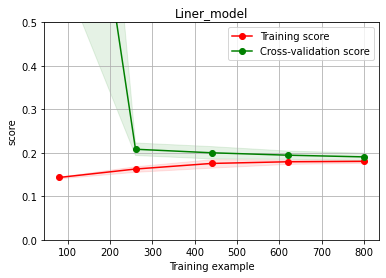

In [58]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

#### 4.4.3 多种模型对比

In [59]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

#### 4.4.3 - 1 线性模型 & 嵌入式特征选择

本章节默认，学习者已经了解关于过拟合、模型复杂度、正则化等概念。否则请寻找相关资料或参考如下连接：

  - 用简单易懂的语言描述「过拟合 overfitting」？ https://www.zhihu.com/question/32246256/answer/55320482
  - 模型复杂度与模型的泛化能力 http://yangyingming.com/article/434/
  - 正则化的直观理解 https://blog.csdn.net/jinping_shi/article/details/52433975

在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [61]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [62]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


对三种方法的效果对比

In [63]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750417086915647


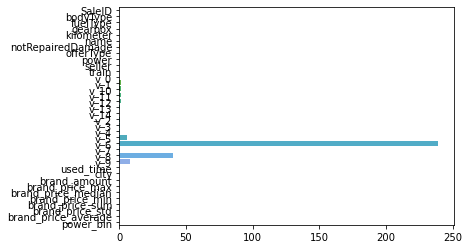

In [64]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』

intercept:4.671709787512927


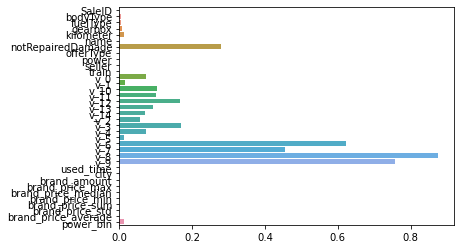

In [65]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与used_time特征非常重要。

intercept:8.672182402894254


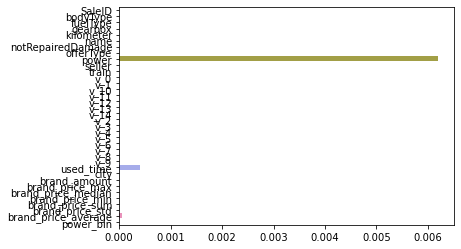

In [67]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的

#### 4.4.3 - 2 非线性模型

除了线性模型以外，还有许多我们常用的非线性模型如下，在此篇幅有限不再一一讲解原理。我们选择了部分常用模型与线性模型进行效果比对。

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [72]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [74]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [75]:
result

{'LinearRegression': array([0.19079177, 0.19375821, 0.194132  , 0.19182523, 0.19575788]),
 'DecisionTreeRegressor': array([0.1982057 , 0.19256385, 0.19086286, 0.19056209, 0.20663404]),
 'RandomForestRegressor': array([0.1324685 , 0.1350402 , 0.13352892, 0.13277665, 0.13693753]),
 'GradientBoostingRegressor': array([0.16889734, 0.17185025, 0.17088592, 0.16906366, 0.17407194]),
 'MLPRegressor': array([679.72549457, 306.20833191, 641.96619075, 323.8599762 ,
        243.81242796]),
 'XGBRegressor': array([0.14233316, 0.14098739, 0.13926624, 0.13739862, 0.14399824]),
 'LGBMRegressor': array([0.14154606, 0.14550104, 0.14388693, 0.14249656, 0.14485158])}

In [76]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.198206,0.132469,0.168897,679.725495,0.142333,0.141546
cv2,0.193758,0.192564,0.135040,0.171850,306.208332,0.140987,0.145501
cv3,0.194132,0.190863,0.133529,0.170886,641.966191,0.139266,0.143887
cv4,0.191825,0.190562,0.132777,0.169064,323.859976,0.137399,0.142497
cv5,0.195758,0.206634,0.136938,0.174072,243.812428,0.143998,0.144852


可以看到随机森林模型在每一个fold中均取得了更好的效果

#### 4.4.4  模型调参

在此我们介绍了三种常用的调参方法如下：

  - 贪心算法 https://www.jianshu.com/p/ab89df9759c8
  - 网格调参 https://blog.csdn.net/weixin_43172660/article/details/83032029
  - 贝叶斯调参 https://blog.csdn.net/linxid/article/details/81189154

In [77]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

#### 4.4.4 - 1 贪心调参

In [78]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

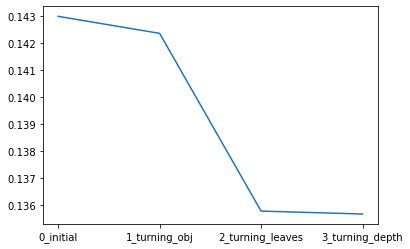

In [79]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

#### 4.4.4 - 2 Grid Search 调参

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [82]:
clf.best_params_

{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [83]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [84]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.13754820909576437

#### 4.4.4 - 3 贝叶斯调参

In [87]:
from bayes_opt import BayesianOptimization

In [88]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [89]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [90]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8273   |  56.17    |  17.35    |  6.823    |  0.8486   |
|  2        |  0.8571   |  63.36    |  77.9     |  30.18    |  0.6484   |
|  3        |  0.8063   |  2.762    |  23.25    |  34.09    |  0.3405   |
|  4        |  0.864    |  11.9     |  6.712    |  55.97    |  0.7736   |
|  5        |  0.8656   |  95.99    |  49.96    |  62.39    |  0.44     |
|  6        |  0.8062   |  2.0      |  100.0    |  100.0    |  1.0      |
|  7        |  0.8691   |  100.0    |  2.0      |  100.0    |  1.0      |
|  8        |  0.8119   |  96.08    |  99.98    |  4.589    |  0.9976   |
|  9        |  0.869    |  97.58    |  99.66    |  99.58    |  0.2671   |
|  10       |  0.8654   |  94.18    |  46.73    |  61.08    |  0.7279   |
|  11       |  0.8692   |  41.89    |  16.5     |  99.84    |  0.2798   |
|  12       |  0.8654   |  56.83    | 

In [91]:
1 - rf_bo.max['target']

0.1305403212134959

## 总结

在本章中，我们完成了建模与调参的工作，并对我们的模型进行了验证。此外，我们还采用了一些基本方法来提高预测的精度，提升如下图所示。

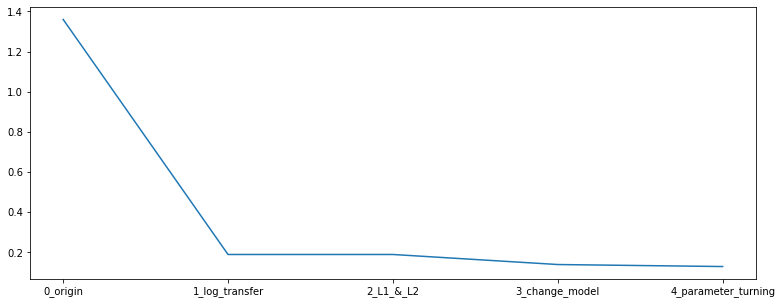

In [92]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])